### Why hospital readmissions matter?

#### A hospital readmission is when a patient who is discharged from the hospital, gets re-admitted again within a certain period of time. Hospital readmission rates for certain conditions are now considered an indicator of hospital quality, and also affect the cost of care adversely. For this reason, Centers for Medicare & Medicaid Services established the Hospital Readmissions Reduction Program which aims to improve quality of care for patients and reduce healthcare spending by applying payment penalties to hospitals that have more than expected readmission rates for certain conditions. Although diabetes is not yet included in the penalty measures, the program is regularly adding new disease conditions to the list, now totalling 6 for FY2018. In 2011, American hospitals spent over 41 billion dollars on diabetic patients who got readmitted within 30 days of discharge. Being able to determine factors that lead to higher readmission in such patients, and correspondingly being able to predict which patients will get readmitted can help hospitals save millions of dollars while improving quality of care. So, with that background in mind, we used a medical claims dataset (description below), to answer these questions:

#####     What factors are the strongest predictors of hospital readmission in diabetic patients?

#####     How well can we predict hospital readmission in this dataset with limited features?

#### Choosing a dataset

##### Finding a good dataset is one of the first challenges (besides defining a meaningful question), when trying out machine learning methods. The current state of the healthcare world is such that we can easily find datasets that rich (full of useful information) but dirty (unstructured content or messy schemas) or datasets that are very clean but otherwise sterile in terms of information contained.

##### With this limitation, we picked a publicly available dataset from UCI repository (link) containing de-identified diabetes patient encounter data for 130 US hospitals containing 101,766 observations over 10 years. The dataset has over 50 features including patient characteristics, conditions, tests and 23 medications. Only diabetic encounters are included (i.e. at least one of three primary diagnosis was diabetes). This dataset has been used by Strack et al. in 2014 for an interesting analysis on the same topic. So we begin by loading the dataset (csv file downloaded from the link above) as a pandas dataframe:

In [1]:
# import libraries needed
import IPython
import pandas as pd
import numpy as np
from statistics import mode
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# it's needed to install sklearn
#pip install -U scikit-learn

In [2]:
# load original data into dataframe and check shape
df_ori = pd.read_csv("diabetic_data.csv")
print(df_ori.shape)

(101766, 50)


In [3]:
# examine the data types and descriptive stats
print(df_ori.info())
print(df_ori.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [4]:
# make a copy of the dataframe for preprocessing
df = df_ori.copy(deep=True)

##### The first thing to do when picking a dataset is to do some data profiling and look at key features, as we have done in the table below:

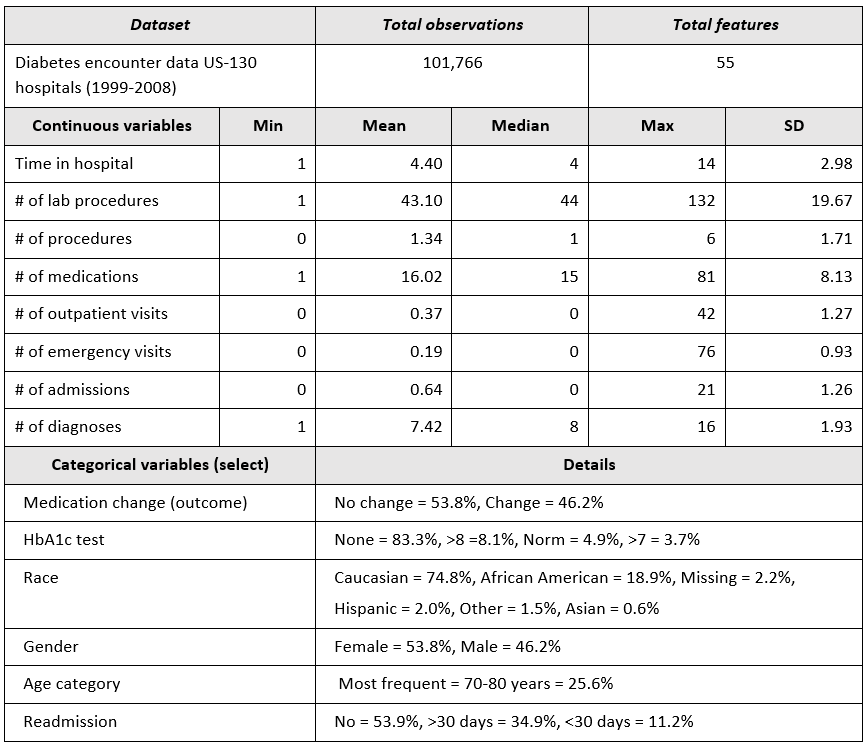

In [5]:
from IPython.display import Image
Image(filename='Data_Description.png') 

#### What preprocessing and feature engineering techniques should be applied?

##### Before we can get to actual modeling, some wrangling with the data is almost always needed. We applied three types of methods here:

##### 1. Cleaning tasks such as dropping bad data, dealing with missing values.
##### 2. Modification of existing features e.g. standardization, log transforms etc.
##### 3. Creation or derivation of new features, usually from existing ones.

##### The individual steps are described in detail below. However, note that what looks like a nice sequence of steps now, was a result of many trial and error attempts to see what works well for getting our data into best shape.

#### Dealing with missing values:

##### First we have to see how many missing values are (which were coded as “?” for most variables in the data):

In [6]:
for col in df.columns:
    if df[col].dtype == object:
        print(col,df[col][df[col] == '?'].count())
        
# gender was coded differently so we use a custom count for this one
print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count())

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
gender 3


##### This gives us a long list but the following variables had missing values:

In [7]:
for col in df.columns:
    if df[col].dtype == object:
        #print(col,df[col][df[col] == '?'].count())
        if (df[col][df[col] == '?'].count() > 0):
            print(col,df[col][df[col] == '?'].count())
        
# gender was coded differently so we use a custom count for this one
print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count())

race 2273
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
gender 3


#### Now the important part — deciding what to do:

##### Weight is missing in over 98% records. Owing to the poor interpretability of missing values and little predictive generalizability to other patients, best thing is to just drop it.

##### Medical Specialty of treating physician also have 40–50% missing values. We decided to drop this, but there are other ways too to deal with such missing values.

In [8]:
df= df.drop(['weight','medical_specialty'], axis = 1)

In [9]:
df.payer_code.unique()

array(['?', 'MC', 'MD', 'HM', 'UN', 'BC', 'SP', 'CP', 'SI', 'DM', 'CM',
       'CH', 'PO', 'WC', 'OT', 'OG', 'MP', 'FR'], dtype=object)

In [10]:
df['payer_code'] = df['payer_code'].replace('?', 'Other')

##### Primary (diag_1), Secondary (diag_2) and Additional (diag_3) diagnoses were have very few missing values. Technically, if all three are missing, that’s bad data. So we only drop those records where all three diagnoses are missing.

##### Gender has only 3 missing or invalid values so we decided to drop these records.

##### Also, one more cleaning step that depends on understanding the data and some common sense: since we are trying to predict readmissions, those patients who died during this hospital admission, have zero probability of readmission. So we should remove those records (discharge_disposition = 11).

In [11]:
drop_Idx = set(df[(df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')].index)
drop_Idx = drop_Idx.union(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 11].index))
#drop_Idx
#len(drop_Idx)

new_Idx = list(set(df.index) - set(drop_Idx))
df = df.iloc[new_Idx]

##### We also noticed that for two variables (drugs named citoglipton and examide), all records have the same value. So essentially these cannot provide any interpretive or discriminatory information for predicting readmission, and we dropped these columns as well. Technically, this isn’t a missing value problem but rather a missing information problem.

In [12]:
df = df.drop(['citoglipton', 'examide'], axis = 1)

#### Creating and/or Recoding New Features

##### This is highly subjective, and partly depends on a knowledge of healthcare services, and making sense of the potential relationships between features. There are perhaps thousands of ways to try here. We tried some (none are perfect) and here’s why.

##### Service utilization: The data contains variables for number of inpatient (admissions), emergency room visits and outpatient visits for a given patient in the previous one year. These are (crude) measures of how much hospital/clinic services a person has used in the past year. We added these three to create a new variable called service utilization (see figure below). The idea was to see which version gives us better results. Granted, we did not apply any special weighting to the three ingredients of service utilization but we wanted to try something simple at this stage.

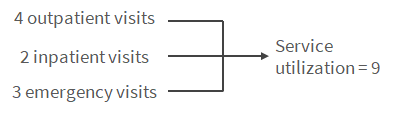

In [13]:
Image(filename='Service_utilization.png')

In [14]:
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

##### Number of medication changes: The dataset contains 23 features for 23 drugs (or combos) which indicate for each of these, whether a change in that medication was made or not during the current hospital stay of patient. Medication change for diabetics upon admission has been shown by previous research to be associated with lower readmission rates. We decided to count how many changes were made in total for each patient, and declared that a new feature. The reasoning here was to both simplify the model and possibly discover a relationship with number of changes regardless of which drug was changed.

In [15]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',\
        'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',\
        'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone',\
        'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)

df['numchange'] = 0

for col in keys:
    colname = str(col) + 'temp'
    df['numchange'] = df['numchange'] + df[colname]
    del df[colname]

##### To check the result of doing this, we use the value_counts() method which gives a nice tapering distribution:

In [16]:
df['numchange'].value_counts()

0    72868
1    25832
2     1308
3      107
4        5
Name: numchange, dtype: int64

##### Number of medication used: Another possibly related factor could be the total number of medications used by the patient (which may indicate severity of their condition and/or the intensity of care). So we created another feature by counting the medications used during the encounter (keys variable in code below is continued from above):

In [17]:
for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No') else 1)

df['nummed'] = 0

for col in keys:
    colname = str(col) + 'temp'
    df['nummed'] = df['nummed'] + df[colname]
    del df[colname]
    
df['nummed'].value_counts()

1    46438
0    22844
2    21712
3     7738
4     1325
5       58
6        5
Name: nummed, dtype: int64

##### Categorization of diagnoses: The dataset contained upto three diagnoses for a given patient (primary, secondary and additional). However, each of these had 700–900 unique ICD codes and it is extremely difficult to include them in the model and interpret meaningfully. Therefore, we collapsed these diagnosis codes into 9 disease categories in an almost similar fashion to that done in the original publication using this dataset. These 9 categories include Circulatory, Respiratory, Digestive, Diabetes, Injury, Musculoskeletal, Genitourinary, Neoplasms, and Others. Although we did this for primary, secondary and additional diagnoses, we eventually decided to use only the primary diagnosis in our model.

In [18]:
# create a duplicate of the diagnosis column
df['level1_diag1'] = df['diag_1']

In [19]:
# disease codes starting with V or E are in “other” category; so recode them to 0
df.loc[df['diag_1'].str.contains('V'), ['level1_diag1']] = 0
df.loc[df['diag_1'].str.contains('E'), ['level1_diag1']] = 0

In [20]:
# also replace the unknown values with -1
df['level1_diag1'] = df['level1_diag1'].replace('?', -1)

In [21]:
# iterate and recode disease codes between certain ranges to certain categories
for index, row in df.iterrows():
    if (np.float(row['level1_diag1']) >= 390 and np.float(row['level1_diag1']) < 460) or ((np.float(row['level1_diag1']) >= 785) and (np.float(row['level1_diag1']) <= 786)):
        df.loc[index, 'level1_diag1'] = 1
    elif (np.float(row['level1_diag1']) >= 460 and np.float(row['level1_diag1']) < 520) or ((np.float(row['level1_diag1']) >= 786) and (np.float(row['level1_diag1']) <= 787)):
        df.loc[index, 'level1_diag1'] = 2
    elif (np.float(row['level1_diag1']) >= 520 and np.float(row['level1_diag1']) < 580) or ((np.float(row['level1_diag1']) >= 787) and (np.float(row['level1_diag1']) <= 788)):
        df.loc[index, 'level1_diag1'] = 3
    elif ((np.float(row['level1_diag1']) >= 250) and (np.float(row['level1_diag1']) <= 251)):
        df.loc[index, 'level1_diag1'] = 4
    elif (np.float(row['level1_diag1']) >= 800 and np.float(row['level1_diag1']) < 1000):
        df.loc[index, 'level1_diag1'] = 5
    elif (np.float(row['level1_diag1']) >= 710 and np.float(row['level1_diag1']) < 740):
        df.loc[index, 'level1_diag1'] = 6
    elif (np.float(row['level1_diag1']) >= 580 and np.float(row['level1_diag1']) < 630) or ((np.float(row['level1_diag1']) >= 788) and (np.float(row['level1_diag1']) <= 789)):
        df.loc[index, 'level1_diag1'] = 7
    elif (np.float(row['level1_diag1']) >= 140 and np.float(row['level1_diag1']) < 240):
        df.loc[index, 'level1_diag1'] = 8
    else:
        df.loc[index, 'level1_diag1'] = 0
        
# convert this variable to float type to enable computations later
df['level1_diag1'] = df['level1_diag1'].astype(float)

In [22]:
df[['diag_1','level1_diag1']].head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
diag_1,250.83,276,648,8,197,414,414,428,398,434,250.7,157,428,428,518
level1_diag1,4,0,0,0,8,1,1,1,1,1,4,8,1,1,2


In [23]:
# save the work into a csv file as backup
#df.to_csv('./diabetes_data_preprocessed.csv')

##### Collapsing some other variables: Just like diagnoses, there were quite a few categories for admission source, admission type and discharge disposition. We collapsed these variables into fewer categories where it made sense. For example, admission types 1, 2 and 7 correspond to Emergency, Urgent Care and Trauma, and thus were combined into a single category as these are all non-elective situations.

In [24]:
df['admission_type_id'] = df['admission_type_id'].replace(2,1)
df['admission_type_id'] = df['admission_type_id'].replace(7,1)
df['admission_type_id'] = df['admission_type_id'].replace(6,5)
df['admission_type_id'] = df['admission_type_id'].replace(8,5)

##### Recoding some variables: The original dataset used string values for gender, race, medication change, and each of the 23 drugs used. To better fit those variables into our model, we interpret the variables to numeric binary variables to reflect their nature. For example, we encoded the “medication change” feature from “No” (no change) and “Ch” (changed) into 0 and 1. 

In [25]:
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)

# keys is the same as before
for col in keys:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)

##### We also reduced both A1C test result and Glucose serum test result into categories of Normal, Abnormal and Not tested.

In [26]:
df['A1Cresult'] = df['A1Cresult'].replace('>7', 1)
df['A1Cresult'] = df['A1Cresult'].replace('>8', 1)
df['A1Cresult'] = df['A1Cresult'].replace('Norm', 0)
df['A1Cresult'] = df['A1Cresult'].replace('None', -99)

df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('>300', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 0)
df['max_glu_serum'] = df['max_glu_serum'].replace('None', -99)

##### Recoding the outcome variable: The outcome we are looking at is whether the patient gets readmitted to the hospital within 30 days or not. The variable actually has < 30, > 30 and No Readmission categories. To reduce our problem to a binary classification, we combined the readmission after 30 days and no readmission into a single category:

In [27]:
df['readmitted'] = df['readmitted'].replace('>30', 0)
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('NO', 0)

##### Dealing with age: There are different ways to deal with this. The dataset only gives us age as 10 year categories, so we don’t know the exact age of each patient. The previous study on this dataset used age categories as nominal variables, but we wanted to be able to see the effect of increasing age on readmission, even if in a crude way. To do that, we assume that age of the patient on average lies at the midpoint of the age category. For example, if the patient’s age category is 20–30 years, then we assume the age = 25 years. So we converted age categories to midpoints, resulting in a numeric variable:

In [28]:
age_dict = {'[0-10)':5, '[10-20)':15, '[20-30)':25,\
            '[30-40)':35, '[40-50)':45, '[50-60)':55,\
            '[60-70)':65, '[70-80)':75, '[80-90)':85, '[90-100)':95}
                                                        
df['age'] = df.age.map(age_dict)
df['age'] = df['age'].astype('int64')
                                                        
print(df.age.value_counts())

75    25564
65    22186
55    17102
85    16708
45     9626
35     3765
95     2669
25     1650
15      690
5       160
Name: age, dtype: int64


#### Collapsing of Multiple Encounters for same patient

##### Some patients in the dataset had more than one encounter.We could not count them as independent encounters because that bias the results towards those patients who had multiple encounters. Thus we tried multiple techniques to collapse and consolidate multiple encounters for same patient such as:

##### 1. Considering more than 2 readmissions across multiple encounters as readmission for collapsed record.
##### 2. Considering average stay at hospital across multiple encounters.
##### 3. Considering the percentage of the medication changes across multiple encounters
##### 4. Considering the total number of the encounters to replace the encounter unique ID
##### 5. Considering the combination of diagnoses across multiple encounters as a list

#### However, taking the features such as “diagnosis”, for instance, we did not find it not meaningful to combine multiple categorical values into an array for building data model. We then considered first encounter and last encounter separately as possible representations of multiple encounters. However, last encounters gave extremely imbalanced data for readmissions (96/4 Readmissions vs No Readmissions) and thus, we decided to use first encounters of patients with multiple encounters. This resulted in dataset being reduced to about 70,000 encounters:

In [29]:
df2 = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df2.shape

(70442, 50)

In [30]:
#df2.to_csv('./diabetes_data_preprocessed_dropped_duplicates.csv')

#### Log Transformation

##### A preliminary analysis of our numerical features revealed that many of these were highly skewed and had high kurtosis. As a reference, the skew of a normal distribution is 0 and the excess kurtosis (difference of actual kurtosis from ideal normal distribution value of 3), as returned by the kurtosis() function for a normal distribution is 0, which would impact standardization. Features such as number of emergency visits, service utilization, number of inpatient admissions and number of outpatient visits had high skew and kurtosis. Thus, we performed log transformation where a skew or kurtosis beyond the limits of -2 ≤ skew and kurtosis ≤ 2. Also, since log (0) is not defined, we decided to use the following rule:

##### 1. Compute log(x) for any feature x if percentage of 0s in x ≤ 2%, after removing the zeros. This ensured that we didn’t bulk-remove records that hold predictive power for other columns.
##### 2. Compute log1p(x) otherwise (log1p(x) means log(x+1), while retaining the zeros.

##### To perform the actual log transform we create a new column and set it equal to np.log or np.log1p of the column to be transformed:

In [31]:
df2.columns.values

array(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'payer_code',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone',
       'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'service_utilization', 'numchange', 'nummed', 'level1_diag1'],
      dtype=object)

In [32]:
for col in df2.columns.values:
    if ((col != 'race') and (col != 'diag_1') and (col != 'diag_2') and (col != 'diag_3') and (col != 'payer_code')):
        if ((len(df2[df2[col].astype(str).str.contains('0')]) * 100 / len(df2)) <= 2):
            df2[col + "_log"] = np.log(df2[col])
        else:
            df2[col + "_log1p"] = np.log1p(df2[col])

E:\Programs\Anaconda3\envs\no2018\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Programs\Anaconda3\envs\no2018\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
E:\Programs\Anaconda3\envs\no2018\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  


#### Standardization

##### Since we had used log transformation to ensure that the numeric variables had a Gaussian-like or normal distribution (before the log transformation) or were log transformed to ensure a normal distribution, we decided to standardize our numerical features using the formula:

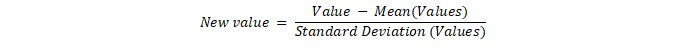

In [33]:
Image(filename='Standardization.png')

In [34]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [35]:
# numerics is a list of all numeric features
numerics = list()

for col in df2.columns.values:
    if ((col != 'race') and (col != 'diag_1') and (col != 'diag_2') and (col != 'diag_3')):
        numerics.append(col)
#print(numerics)

#df2[numerics] = standardize(df2[numerics])

In [36]:
dfNew = df2.copy(deep=True)

#### Interaction Terms

##### Variables can have interdependent effects on readmission, called interactions. We can identify possible candidates for interaction terms by looking at what makes theoretical sense and by observing a correlation matrix of the predictor variables to see which ones seem highly correlated.

In [37]:
# increase row display limit
pd.options.display.max_rows = 400

In [38]:
# calculate correlation matrix and store as absolute values
c = df2.corr().abs()
c

,encounter_id,patient_nbr,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,glimepiride-pioglitazone_log1p,metformin-rosiglitazone_log1p,metformin-pioglitazone_log1p,change_log1p,diabetesMed_log1p,readmitted_log1p,service_utilization_log1p,numchange_log1p,nummed_log1p,level1_diag1_log1p
encounter_id,1.000000,0.502268,0.008878,0.050840,0.129167,0.138216,0.112560,0.069810,0.052845,0.006112,...,NaN,0.008583,0.009258,0.078232,0.040558,0.047290,0.071647,0.079946,0.050286,0.020388
patient_nbr,0.502268,1.000000,0.010191,0.062052,0.019760,0.142239,0.018797,0.017838,0.005831,0.024706,...,NaN,0.011070,0.001302,0.047660,0.020272,0.005357,0.161363,0.049927,0.026595,0.009228
gender,0.008878,0.010191,1.000000,0.052880,0.009726,0.021852,0.003336,0.025157,0.004697,0.066634,...,NaN,0.005681,0.003534,0.018884,0.018882,0.002248,0.019896,0.011395,0.027143,0.011394
age,0.050840,0.062052,0.052880,1.000000,0.006789,0.104012,0.043066,0.128561,0.026617,0.024340,...,NaN,0.003162,0.000122,0.035260,0.022551,0.045736,0.023704,0.069311,0.007478,0.007208
admission_type_id,0.129167,0.019760,0.009726,0.006789,1.000000,0.097949,0.134034,0.027439,0.136390,0.122352,...,NaN,0.000605,0.003177,0.002236,0.011115,0.002709,0.065516,0.008043,0.013776,0.051975
discharge_disposition_id,0.138216,0.142239,0.021852,0.104012,0.097949,1.000000,0.000308,0.165358,0.017516,0.015288,...,NaN,0.000021,0.000346,0.003793,0.019617,0.065327,0.041842,0.010750,0.019463,0.037608
admission_source_id,0.112560,0.018797,0.003336,0.043066,0.134034,0.000308,1.000000,0.007650,0.090763,0.129703,...,NaN,0.002100,0.004199,0.000794,0.001058,0.005445,0.065799,0.023145,0.010104,0.060156
time_in_hospital,0.069810,0.017838,0.025157,0.128561,0.027439,0.165358,0.007650,1.000000,0.332129,0.187856,...,NaN,0.000514,0.002200,0.111446,0.068631,0.054661,0.016975,0.166230,0.084936,0.003546
num_lab_procedures,0.052845,0.005831,0.004697,0.026617,0.136390,0.017516,0.090763,0.332129,1.000000,0.043702,...,NaN,0.001495,0.003771,0.076693,0.045214,0.031723,0.030343,0.128553,0.045399,0.026070
num_procedures,0.006112,0.024706,0.066634,0.024340,0.122352,0.015288,0.129703,0.187856,0.043702,1.000000,...,NaN,0.004791,0.000907,0.006234,0.008124,0.000074,0.044230,0.018037,0.001127,0.030486


In [39]:
# unstake the table
s = c.unstack()
s

encounter_id        encounter_id                      1.000000
                    patient_nbr                       0.502268
                    gender                            0.008878
                    age                               0.050840
                    admission_type_id                 0.129167
                    discharge_disposition_id          0.138216
                    admission_source_id               0.112560
                    time_in_hospital                  0.069810
                    num_lab_procedures                0.052845
                    num_procedures                    0.006112
                    num_medications                   0.056097
                    number_outpatient                 0.070823
                    number_emergency                  0.051751
                    number_inpatient                  0.040226
                    number_diagnoses                  0.257703
                    max_glu_serum                     0

In [40]:
# sort the values in descending order
so = s.sort_values(ascending=False)
so

tolazamide                      tolazamide_log1p                  1.000000
tolazamide_log1p                tolazamide                        1.000000
readmitted                      readmitted_log1p                  1.000000
readmitted_log1p                readmitted                        1.000000
metformin_log1p                 metformin                         1.000000
metformin                       metformin_log1p                   1.000000
insulin                         insulin_log1p                     1.000000
insulin_log1p                   insulin                           1.000000
change                          change_log1p                      1.000000
change_log1p                    change                            1.000000
glipizide-metformin_log1p       glipizide-metformin               1.000000
glipizide-metformin             glipizide-metformin_log1p         1.000000
rosiglitazone_log1p             rosiglitazone                     1.000000
rosiglitazone            

In [41]:
# display the most relevant part of the list
so['number_outpatient_log1p', 'service_utilization_log1p']

0.7536271882994459

In [42]:
so['nummed', 'change']

0.7311847498769142

In [43]:
so['diabetesMed', 'nummed']

0.7068724923035034

#### In this list, there are two kinds of situations:

##### 1. One variable is contained in/derivative of another: In the above examples, number of outpatient visits is part of service utilization. However, we created this feature ourselves, so in this case our decision is to not put these in same feature set (we used two feature sets described later). Similarly, diabetesMed (any diabetic medication prescribed) is contained in the number of medications used. We decided to drop diabetesMed from analysis in this case because, well, it is understood that all of these patients are getting some diabetic medication.

##### 2. Possible actual co-variance: The other situation is an actual co-variance between two variables. This seems to be the case for number of medication and whether a change was made or not, and it also makes some intuitive sense. So we created interaction terms for such cases.

In [44]:
interactionterms = [('num_medications','time_in_hospital'),\
                    ('num_medications','num_procedures'),\
                    ('time_in_hospital','num_lab_procedures'),\
                    ('num_medications','num_lab_procedures'),\
                    ('num_medications','number_diagnoses'),\
                    ('age','number_diagnoses'),\
                    ('change','num_medications'),\
                    ('number_diagnoses','time_in_hospital'),\
                    ('num_medications','numchange')]
 
for inter in interactionterms:
    name = inter[0] + '|' + inter[1]
    df[name] = df[inter[0]] * df[inter[1]]

In [45]:
dfTest = df2.copy(deep=True)

In [46]:
dfTest['race'] = dfTest['race'].replace('?', 'Other')

In [47]:
uni = dfTest.race.unique()
uni

array(['Caucasian', 'AfricanAmerican', 'Other', 'Asian', 'Hispanic'],
      dtype=object)

In [48]:
dfTest.to_csv('./diabetes_data_preprocessed_dropped_duplicates_1.csv')

In [49]:
#dfTest['race'] = dfTest['race'].replace('Caucasian', 0)
#dfTest['race'] = dfTest['race'].replace('AfricanAmerican', 1)
#dfTest['race'] = dfTest['race'].replace('Other', 2)
#dfTest['race'] = dfTest['race'].replace('Asian', 3)
#dfTest['race'] = dfTest['race'].replace('Hispanic', 4)

dfTest = pd.concat([dfTest,pd.get_dummies(dfTest['race'].values, prefix='race')],axis=1)

# now drop the original 'race' column (you don't need it anymore)
dfTest.drop(['race'],axis=1, inplace=True)

In [50]:
# calculate correlation matrix and store as absolute values
corrMatr = dfTest.corr().abs()
#corrMatr
corrMatr['race_Other'].sort_values(ascending=False)

race_Other                        1.000000
race_Caucasian                    0.368141
race_AfricanAmerican              0.100248
race_Hispanic                     0.031605
encounter_id                      0.019805
race_Asian                        0.017915
max_glu_serum_log1p               0.013184
glipizide                         0.013142
glipizide_log1p                   0.013142
number_diagnoses                  0.012310
patient_nbr                       0.010950
numchange_log1p                   0.010811
number_diagnoses_log              0.010623
num_lab_procedures                0.010582
numchange                         0.009841
encounter_id_log1p                0.008625
num_lab_procedures_log1p          0.008241
A1Cresult                         0.008238
miglitol_log1p                    0.007241
miglitol                          0.007241
tolbutamide_log1p                 0.007241
tolbutamide                       0.007241
tolazamide_log1p                  0.006913
tolazamide 

In [51]:
unstk = corrMatr.unstack()
unstk

encounter_id    encounter_id                      1.000000
                patient_nbr                       0.502268
                gender                            0.008878
                age                               0.050840
                admission_type_id                 0.129167
                discharge_disposition_id          0.138216
                admission_source_id               0.112560
                time_in_hospital                  0.069810
                num_lab_procedures                0.052845
                num_procedures                    0.006112
                num_medications                   0.056097
                number_outpatient                 0.070823
                number_emergency                  0.051751
                number_inpatient                  0.040226
                number_diagnoses                  0.257703
                max_glu_serum                     0.146346
                A1Cresult                         0.0297

In [52]:
soVal = unstk.sort_values(ascending=False)
soVal

tolazamide_log1p                tolazamide                        1.000000
tolazamide                      tolazamide_log1p                  1.000000
readmitted_log1p                readmitted                        1.000000
readmitted                      readmitted_log1p                  1.000000
metformin                       metformin_log1p                   1.000000
metformin_log1p                 metformin                         1.000000
insulin                         insulin_log1p                     1.000000
insulin_log1p                   insulin                           1.000000
change                          change_log1p                      1.000000
change_log1p                    change                            1.000000
glipizide-metformin             glipizide-metformin_log1p         1.000000
glipizide-metformin_log1p       glipizide-metformin               1.000000
rosiglitazone                   rosiglitazone_log1p               1.000000
rosiglitazone_log1p      

In [53]:
correlations = dfTest.corr()
correlations

,encounter_id,patient_nbr,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,readmitted_log1p,service_utilization_log1p,numchange_log1p,nummed_log1p,level1_diag1_log1p,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other
encounter_id,1.000000,0.502268,0.008878,0.050840,-0.129167,-0.138216,-0.112560,-0.069810,-0.052845,-0.006112,...,-0.047290,0.071647,0.079946,0.050286,0.020388,-0.065303,0.020659,0.039012,0.018288,0.019805
patient_nbr,0.502268,1.000000,0.010191,0.062052,-0.019760,-0.142239,-0.018797,-0.017838,0.005831,-0.024706,...,0.005357,0.161363,0.049927,0.026595,0.009228,-0.032714,0.002426,0.021909,0.004950,0.010950
gender,0.008878,0.010191,1.000000,-0.052880,0.009726,-0.021852,0.003336,-0.025157,0.004697,0.066634,...,-0.002248,-0.019896,0.011395,0.027143,-0.011394,0.000517,0.002086,0.005129,-0.008755,-0.006619
age,0.050840,0.062052,-0.052880,1.000000,-0.006789,0.104012,0.043066,0.128561,0.026617,-0.024340,...,0.045736,0.023704,-0.069311,-0.007478,-0.007208,-0.004715,0.001050,0.004452,0.004506,-0.004186
admission_type_id,-0.129167,-0.019760,0.009726,-0.006789,1.000000,0.097949,0.134034,-0.027439,-0.136390,0.122352,...,-0.002709,0.065516,0.008043,-0.013776,0.051975,0.002093,-0.002418,-0.003737,0.001801,0.003709
discharge_disposition_id,-0.138216,-0.142239,-0.021852,0.104012,0.097949,1.000000,-0.000308,0.165358,0.017516,0.015288,...,0.065327,-0.041842,0.010750,-0.019463,0.037608,0.001241,0.000661,-0.001360,0.004715,-0.003065
admission_source_id,-0.112560,-0.018797,0.003336,0.043066,0.134034,-0.000308,1.000000,0.007650,0.090763,-0.129703,...,0.005445,0.065799,0.023145,-0.010104,-0.060156,0.010816,-0.007294,-0.007911,0.002383,-0.002490
time_in_hospital,-0.069810,-0.017838,-0.025157,0.128561,-0.027439,0.165358,0.007650,1.000000,0.332129,0.187856,...,0.054661,0.016975,0.166230,0.084936,-0.003546,-0.002457,-0.003509,0.002756,0.001987,-0.001265
num_lab_procedures,-0.052845,0.005831,0.004697,0.026617,-0.136390,0.017516,0.090763,0.332129,1.000000,0.043702,...,0.031723,0.030343,0.128553,0.045399,-0.026070,-0.001035,0.001230,-0.006877,0.008031,0.010582
num_procedures,-0.006112,-0.024706,0.066634,-0.024340,0.122352,0.015288,-0.129703,0.187856,0.043702,1.000000,...,0.000074,-0.044230,0.018037,0.001127,0.030486,-0.004196,0.000289,0.002951,-0.003596,0.004123


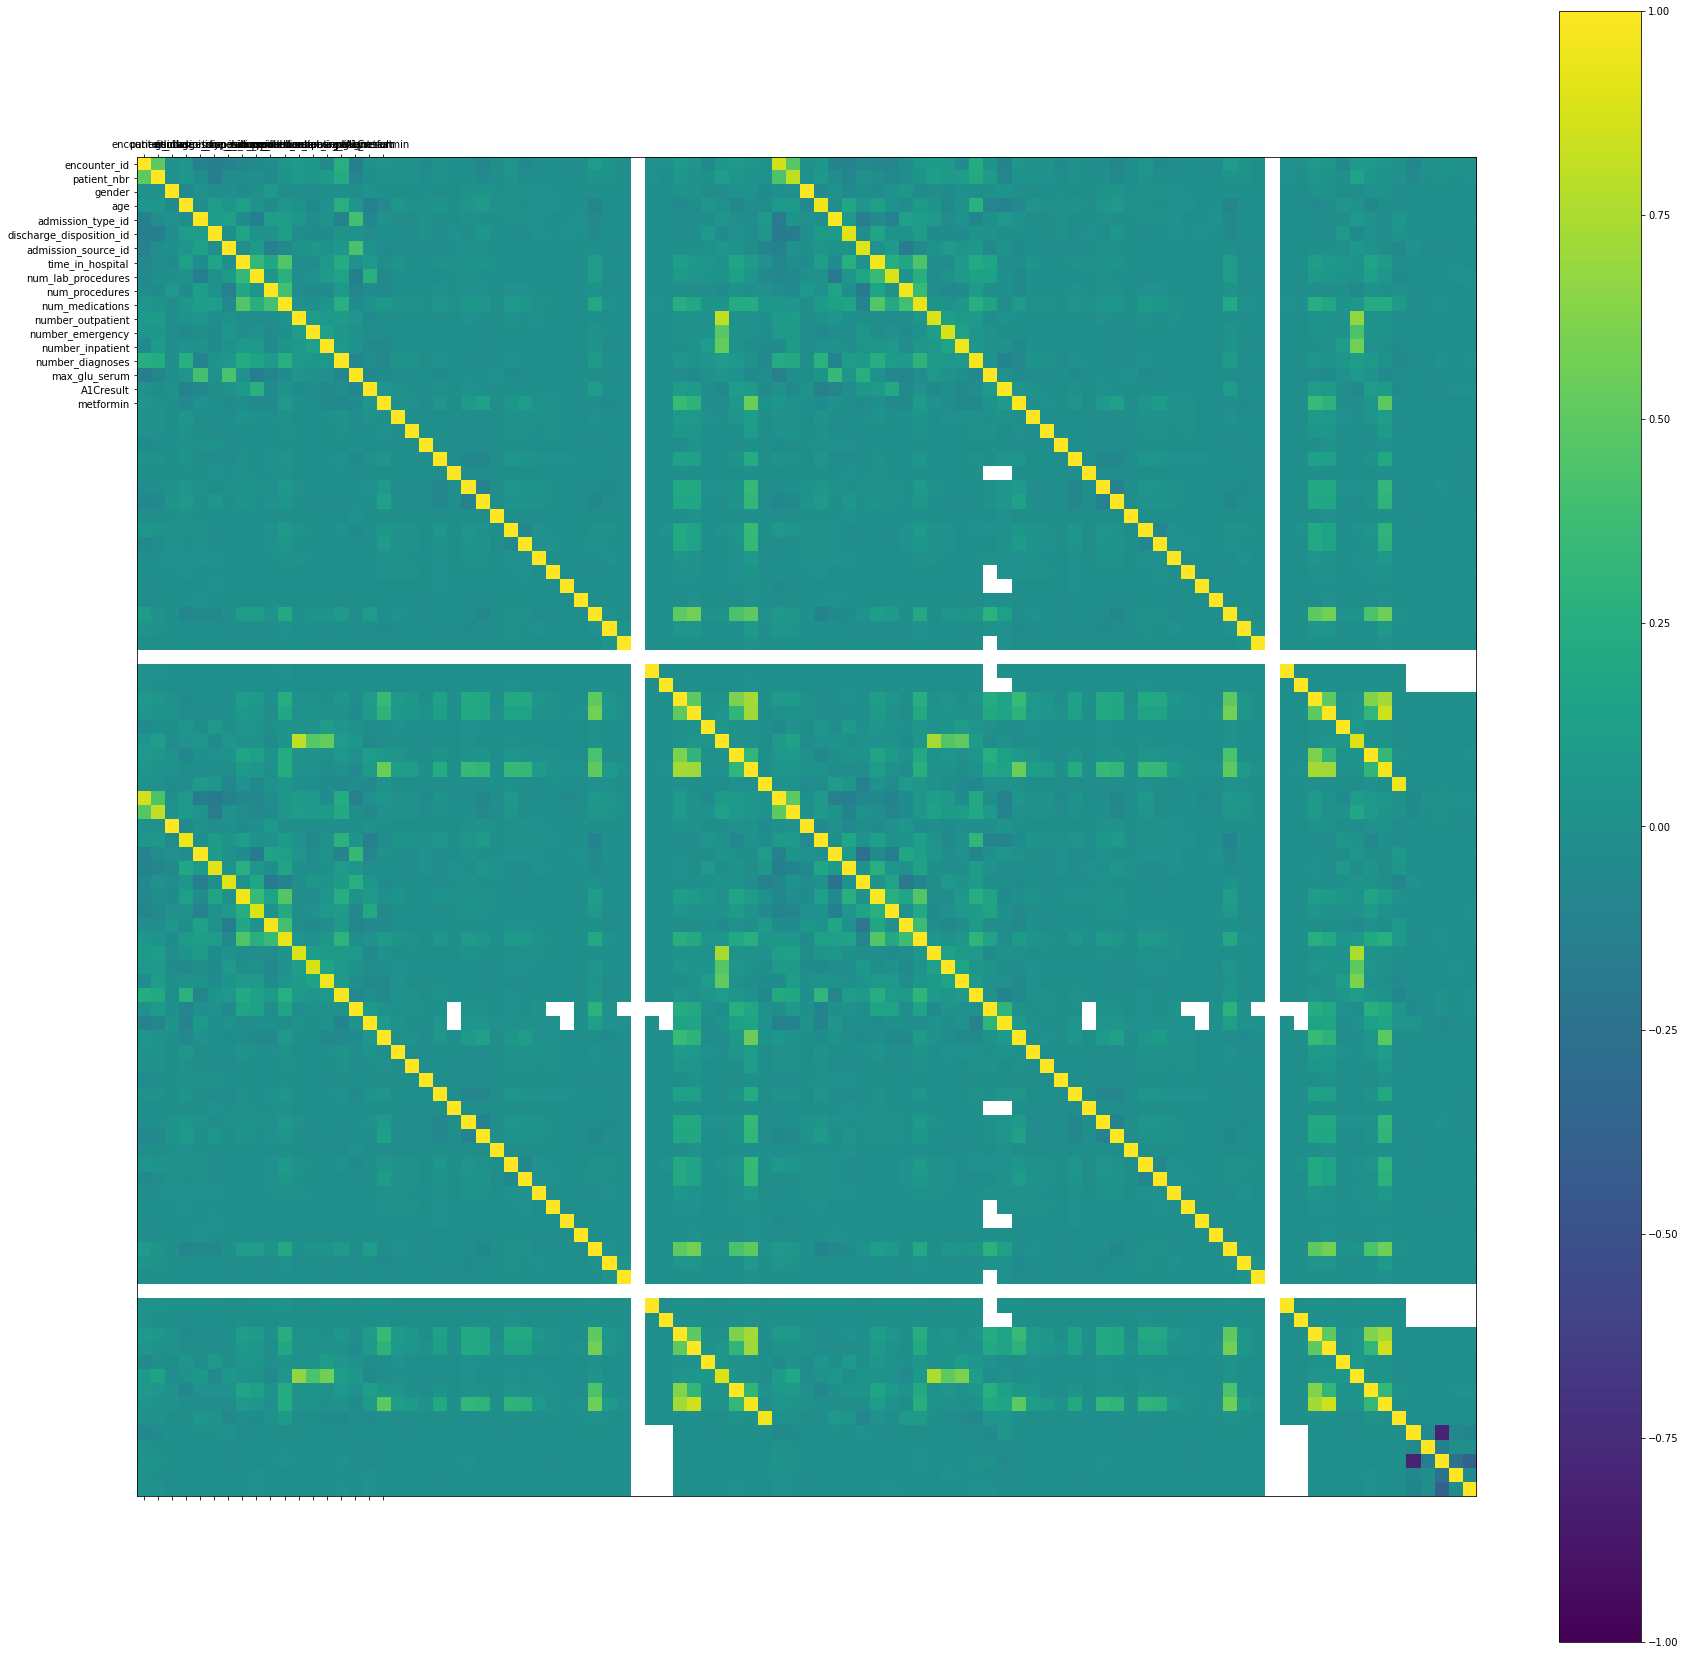

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# plot correlation matrix

names = list(correlations.columns)
fig = plt.figure(figsize=[30,30])
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,18,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [55]:
s1 = correlations.unstack()
so1 = s1.sort_values(kind="quicksort", ascending=False)

so1

tolazamide_log1p                tolazamide                        1.000000
tolazamide                      tolazamide_log1p                  1.000000
readmitted_log1p                readmitted                        1.000000
readmitted                      readmitted_log1p                  1.000000
metformin                       metformin_log1p                   1.000000
metformin_log1p                 metformin                         1.000000
insulin                         insulin_log1p                     1.000000
insulin_log1p                   insulin                           1.000000
change                          change_log1p                      1.000000
change_log1p                    change                            1.000000
glipizide-metformin             glipizide-metformin_log1p         1.000000
glipizide-metformin_log1p       glipizide-metformin               1.000000
rosiglitazone                   rosiglitazone_log1p               1.000000
rosiglitazone_log1p      

#### Represent the scatterplots of the three most correlated pairs of variables, including 'race'

In [56]:
from pandas.plotting import scatter_matrix
import random

In [57]:
# The three most correlated pairs of variables are (race_Other,race_Caucasian), (race_Other,race_AfricanAmerican), (race_Other,race_Hispanic)

df1 = pd.DataFrame(data=dfTest, columns=['race_Other', 'race_Caucasian'])
df2 = pd.DataFrame(data=dfTest, columns=['race_Other', 'race_AfricanAmerican'])
df3 = pd.DataFrame(data=dfTest, columns=['race_Other', 'race_Hispanic'])
#df1, df2, df3

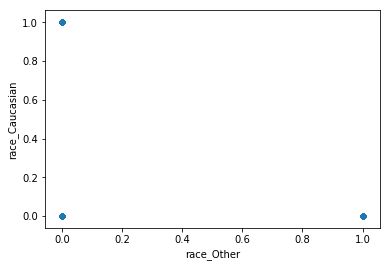

In [58]:
df1.plot(kind='scatter', x='race_Other', y='race_Caucasian');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DC9CBAD8D0>,
      dtype=object)

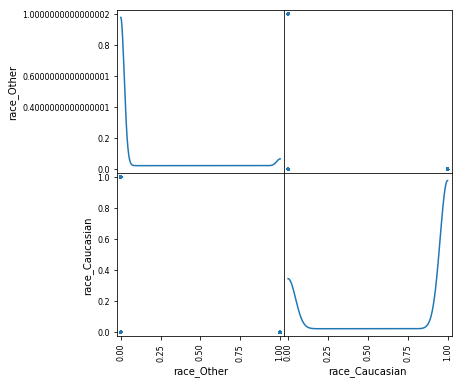

In [59]:
scatter_matrix(df1, alpha=0.2, figsize=(6, 6), diagonal='kde')

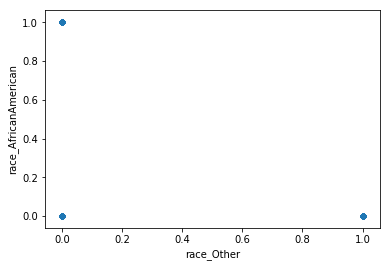

In [60]:
df2.plot(kind='scatter', x='race_Other', y='race_AfricanAmerican');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DC9CC692B0>,
      dtype=object)

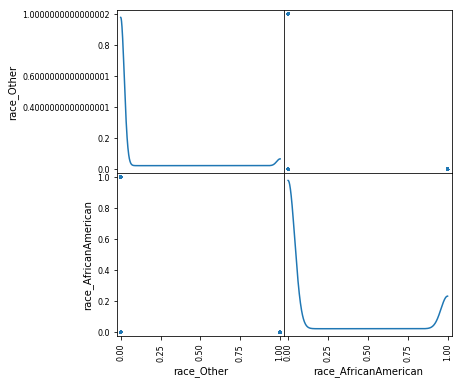

In [61]:
scatter_matrix(df2, alpha=0.2, figsize=(6, 6), diagonal='kde')

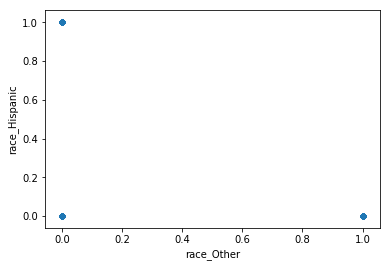

In [62]:
df3.plot(kind='scatter', x='race_Other', y='race_Hispanic');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DC9EC52908>,
      dtype=object)

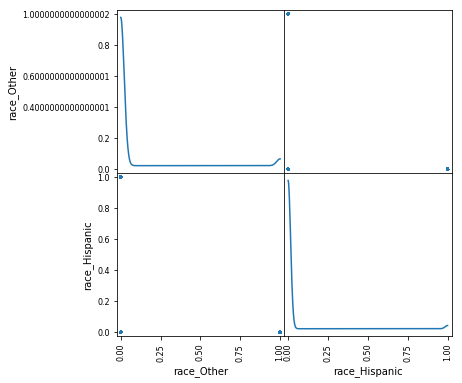

In [63]:
scatter_matrix(df3, alpha=0.2, figsize=(6, 6), diagonal='kde')

In [64]:
dfTest= dfTest.drop(['diag_1','diag_2', 'diag_3'], axis = 1)

In [65]:
dfTest.to_csv('./diabetes_data_preprocessed_dropped_duplicates_1.csv')

In [66]:
pc = dfTest.payer_code.unique()
pc

array(['Other', nan, 'MC', 'MD', 'HM', 'UN', 'BC', 'SP', 'CP', 'SI', 'DM',
       'CM', 'CH', 'PO', 'WC', 'OT', 'OG', 'MP', 'FR'], dtype=object)

In [67]:
#dfTest['payer_code'] = dfTest['payer_code'].replace('Other', 0)
#dfTest['payer_code'] = dfTest['payer_code'].replace('MC', 1)
#dfTest['payer_code'] = dfTest['payer_code'].replace('MD', 2)
#dfTest['payer_code'] = dfTest['payer_code'].replace('HM', 3)
#dfTest['payer_code'] = dfTest['payer_code'].replace('UN', 4)
#dfTest['payer_code'] = dfTest['payer_code'].replace('BC', 5)
#dfTest['payer_code'] = dfTest['payer_code'].replace('SP', 6)
#dfTest['payer_code'] = dfTest['payer_code'].replace('CP', 7)
#dfTest['payer_code'] = dfTest['payer_code'].replace('SI', 8)
#dfTest['payer_code'] = dfTest['payer_code'].replace('DM', 9)
#dfTest['payer_code'] = dfTest['payer_code'].replace('CM', 10)
#dfTest['payer_code'] = dfTest['payer_code'].replace('CH', 11)
#dfTest['payer_code'] = dfTest['payer_code'].replace('PO', 12)
#dfTest['payer_code'] = dfTest['payer_code'].replace('WC', 13)
#dfTest['payer_code'] = dfTest['payer_code'].replace('OT', 14)
#dfTest['payer_code'] = dfTest['payer_code'].replace('OG', 15)
#dfTest['payer_code'] = dfTest['payer_code'].replace('MP', 16)
#dfTest['payer_code'] = dfTest['payer_code'].replace('FR', 17)

dfTest = pd.concat([dfTest,pd.get_dummies(dfTest['payer_code'].values, prefix='payer_code')],axis=1)
dfTest.drop(['payer_code'],axis=1, inplace=True)

In [68]:
dfTest.to_csv('./diabetes_data_preprocessed_dropped_duplicates_1.csv')

In [69]:
dfNaN = dfTest[dfTest.isnull().any(axis=1)]

In [70]:
dfTest['max_glu_serum'] = dfTest['max_glu_serum'].replace(-99, 0)
dfTest['A1Cresult'] = dfTest['A1Cresult'].replace(-99, 0)

In [71]:
dfTest= dfTest.drop(['max_glu_serum_log1p','A1Cresult_log1p'], axis = 1)

In [72]:
dfTest.to_csv('./diabetes_data_preprocessed_dropped_duplicates_1.csv')

In [73]:
dfTest.isnull().sum()

encounter_id                      26756
patient_nbr                       26756
gender                            26756
age                               26756
admission_type_id                 26756
discharge_disposition_id          26756
admission_source_id               26756
time_in_hospital                  26756
num_lab_procedures                26756
num_procedures                    26756
num_medications                   26756
number_outpatient                 26756
number_emergency                  26756
number_inpatient                  26756
number_diagnoses                  26756
max_glu_serum                     26756
A1Cresult                         26756
metformin                         26756
repaglinide                       26756
nateglinide                       26756
chlorpropamide                    26756
glimepiride                       26756
acetohexamide                     26756
glipizide                         26756
glyburide                         26756


In [76]:
temp = dfTest.isnull().sum()
for idx in temp.index:
    dfTest[idx]=dfTest[idx].fillna(0)

In [101]:
for idx in dfTest.index:
    if (dfTest['encounter_id'][idx] == 0.0):
        #print(idx)
        dfTest.drop(idx, inplace = True)

In [108]:
dfTest.reset_index()

,index,encounter_id,patient_nbr,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_Other,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC
0,0,2278392.0,8222157.0,0.0,5.0,5.0,25.0,1.0,1.0,41.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,149190.0,55629189.0,0.0,15.0,1.0,1.0,7.0,3.0,59.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,64410.0,86047875.0,0.0,25.0,1.0,1.0,7.0,2.0,11.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,500364.0,82442376.0,1.0,35.0,1.0,1.0,7.0,2.0,44.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,16680.0,42519267.0,1.0,45.0,1.0,1.0,7.0,1.0,51.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,5,35754.0,82637451.0,1.0,55.0,1.0,1.0,2.0,3.0,31.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,6,55842.0,84259809.0,1.0,65.0,3.0,1.0,2.0,4.0,70.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,7,63768.0,114882984.0,1.0,75.0,1.0,1.0,7.0,5.0,73.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,8,12522.0,48330783.0,0.0,85.0,1.0,1.0,4.0,13.0,68.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,9,15738.0,63555939.0,0.0,95.0,3.0,3.0,4.0,12.0,33.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [125]:
dfTest.to_csv('./diabetes_data_preprocessed_dropped_duplicates_1.csv')